In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import backend as K

import os


In [37]:
labels_path = '/groups/CS156b/data/student_labels/train2023.csv'
df = pd.read_csv(labels_path)
PATHOLOGIES = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                'Lung Opacity', 'Pneumonia', 'Pleural Effusion', 'Pleural Other',
                'Fracture', 'Support Devices']

def get_frontal(df):
    return df.loc[df['Frontal/Lateral'] == 'Frontal']

def get_lateral(df):
    return df.loc[df['Frontal/Lateral'] == 'Lateral']

def get_pathology(df, pathology, val):
    '''Gets all rows where pathology is given value (-1,0,1)'''
    return df.loc[df[pathology] == val]

def get_image_paths(df):
    x = df['Path'].tolist()
    paths = []
    for s in x:
        paths.append("/groups/CS156b/data/" + s)
    return paths

def get_frontal(df):
    return df.loc[df['Frontal/Lateral'] == 'Frontal']

def get_lateral(df):
    return df.loc[df['Frontal/Lateral'] == 'Lateral']

In [38]:
def get_train_test_data(pathology):
    posdf = get_frontal(get_pathology(df, pathology, 1.0))
    negdf = get_frontal(get_pathology(df, pathology, -1.0))

    positive_image_paths = get_image_paths(posdf)
    negative_image_paths = get_image_paths(negdf)
    
    # 50/50 split of positive and negative
    split_num = min(len(positive_image_paths), len(negative_image_paths))
    pos_choice = np.random.choice(positive_image_paths, split_num, replace=False)
    neg_choice = np.random.choice(negative_image_paths, split_num, replace=False)

    image_paths = list(pos_choice) + list(neg_choice)
    labels = (['1'] * split_num) + (['0'] * split_num)

    # Split image paths and labels into training and validation sets
    train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42)
    
    return train_image_paths, val_image_paths, train_labels, val_labels

Found 2088 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


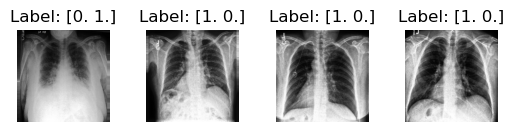

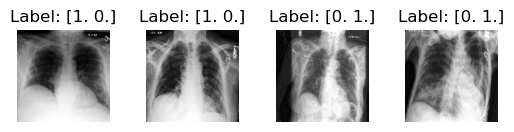

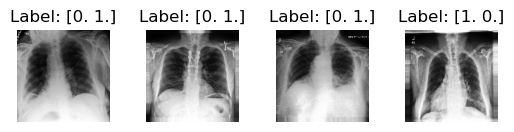

In [79]:
# Split image paths and labels into training and validation sets
train_image_paths, val_image_paths, train_labels, val_labels = get_train_test_data('Pneumonia')

# Define data augmentation and preprocessing
train_data_generator = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    shear_range=0.1,  # Random shear augmentation
    zoom_range=0.1,  # Random zoom augmentation
    horizontal_flip=True  # Random horizontal flip augmentation
)
val_data_generator = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0,1]
)

# Create TensorFlow data generators for training and validation sets
train_data = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_image_paths, 'label': train_labels}),
    directory=None,  # Assuming that image paths are absolute paths
    x_col='filename',
    y_col='label',
#     color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    target_size=(224, 224),
)

val_data = val_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_image_paths, 'label': val_labels}),
    directory=None,  # Assuming that image paths are absolute paths
    x_col='filename',
    y_col='label',
#     color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    target_size=(224, 224)
)

# Visualization code to check batches before training
num_batches_to_display = 3
num_images_to_display_per_batch = 4
for i in range(num_batches_to_display):
    x_batch, y_batch = train_data[i]
    for j in range(num_images_to_display_per_batch):
        plt.subplot(num_batches_to_display, num_images_to_display_per_batch, i*num_images_to_display_per_batch + j + 1)
        plt.imshow(x_batch[j])
        plt.title(f'Label: {y_batch[j]}')
        plt.axis('off')
    plt.subplots_adjust(hspace=0.5)
    plt.show()

# Load pre-trained VGG model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='sigmoid')(x)
x = tf.keras.layers.Dropout(0.2)(x)

predictions = tf.keras.layers.Dense(2, activation='sigmoid')(x)

# Create the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, 0.0001)


In [ ]:
# Train the model
model.fit(
    train_data,
    epochs=1,
    validation_data=val_data,
    verbose=1
)

# Evaluate the model
model.evaluate(val_data)


16/66 [======>.......................] - ETA: 12:10 - loss: 0.7150 - accuracy: 0.5137

In [49]:

model.predict(val_data)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_17/Tanh:0', description="created by layer 'dense_17'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_17/Tanh:0', description="created by layer 'dense_17'")
17/17 [==============================] - 83s 5s/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],